In [1]:
import zfits
import math
import tqdm
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
np.set_printoptions(threshold=np.nan)
%matplotlib inline

In [2]:
diode=1
point_num=2

In [3]:
def sipm_vs_t(f_sample, N, t_offset):
    """
    The FACT SIPM pulse amplitude vs time
    """
    t = np.linspace(0, N/f_sample, num=N, endpoint=False)

    # time line in ns
    t = 1e9*(t-t_offset)

    # evaluate template, here the equation is for nano seconds
    s_vs_t = 1.626*(1.0-np.exp(-0.3803*t))*np.exp(-0.0649*t)
    
    # Since this is only a polynomial approx. 
    # We truncate artefacts like negative amplitudes
    s_vs_t[s_vs_t < 0.0] = 0.0
    return s_vs_t

def convolution(n):
    condata=np.zeros((cleandata.shape[0],np.convolve(template,cleandata[0,:]).shape[0]))
    for i in range(cleandata.shape[0]):
        cap=8*i+n
        if cap>=cleandata.shape[0]:
            break
        condata[cap,:]=np.convolve(template,cleandata[cap,:])
    return condata

def derivative(n):
    dcleandata=np.zeros([condata.shape[0],condata.shape[1]-1])
    for i in range(condata.shape[0]):
        cap=8*i+n
        if cap>=condata.shape[0]:
            break
        for j in range(condata.shape[1]-1):
            dcleandata[cap,j]=condata[cap,j+1]-condata[cap,j]
    return dcleandata

#Keep points where derivative is larger 2 (arbitrary)
def search(n):
    dlarge=dcleandata > 0.4
    for i in range(math.floor(dlarge.shape[0])-1):
        cap=8*i+n
        if cap >=dlarge.shape[0]:
            break
        for entry in range(dlarge.shape[1]):
            if dlarge[cap,entry]==True:
                min=condata[cap,entry]
                max=min
                for i in range(25):
                    if entry-i==0:
                        break
                    if condata[cap,entry-i] <= min:
                        min=condata[cap,entry-i]
                for i in range(50):
                    if i+entry==condata.shape[1]-1:
                        break
                    if condata[cap,entry+i] >= max:
                        max=condata[cap,entry+i]
                if abs(max-min)<5:
                    dlarge[cap,entry]=False
    return dlarge

def middle(n):
    arrivaltimes=np.zeros(slicepos.shape[0],dtype=int)
    #choose the middle of the flanks as their arrivaltimes
    for i in range(condata.shape[0]):
        cap=8*i+n
        if cap >=dlarge.shape[0]:
            break
        for i in range(eventpos.shape[0]):
            if eventpos[i]==cap:
                check=False
                min=condata[cap,slicepos[i]]
                max=min
                for j in range(15):
                    if j+slicepos[i]>=condata.shape[1]-15:
                        arrivaltimes[i]=-1000
                        check=True
                        break
                    if condata[cap,slicepos[i]+j] >= max:
                        max=condata[cap,slicepos[i]+j]
                if check==False:
                    middle=(max-min)/2+min
                    idx = (np.abs(condata[cap,slicepos[i]:slicepos[i]+15]-middle)).argmin()
                    arrivaltimes[i]=idx+slicepos[i]
                    if np.any(condata[cap,arrivaltimes[i]+1:arrivaltimes[i]+25] < middle/2):
                        arrivaltimes[i]=-1000
    return arrivaltimes

showevent=10
showmin1=0
showmin2=0
showmin1p=0
showmin2p=0

def integration(n):
    int_values=np.zeros(eventpos.shape[0])
    for i in range(eventpos.shape[0]):
        cap=8*i+n
        if cap >=dlarge.shape[0]:
            break
        if slicepos[cap]<condata.shape[1]-80:
            min1p=np.argmin(condata[eventpos[cap],slicepos[cap]-10:slicepos[cap]])+slicepos[cap]-10
            min1=condata[eventpos[cap],min1p]
            min2p=np.argmin(condata[eventpos[cap],slicepos[cap]+30:slicepos[cap]+80])+slicepos[cap]+30
            min2=condata[eventpos[cap],min2p]
            step=(min2-min1)/80
            integral=0
            for j in range(30+arrivaltimes[cap]-slicepos[cap]):
                integral+=condata[eventpos[cap],slicepos[cap]+j]-(j*step+min1)
            int_values[cap]=integral
            if cap==showevent:
                showmin1=min1
                showmin1p=min1p
                showmin2=min2
                showmin2p=min2p
    return int_values
    

In [4]:
#MAIN

data=np.load("Data/Diode_"+str(diode)+ "/BV_"+str(diode)+"_"+str(point_num)+".npy")
#data=data[:50,:]
! mkdir -p Results/Diode_$diode/BV/Point_$point_num

cleandata=np.zeros([len(data),data.shape[1]-20-20])
for line_id, dat in enumerate(data):
    cleandata[line_id]=dat[20:-20]

zeroline=np.zeros(50)
_template=np.append(zeroline[0:10],sipm_vs_t(2e9,200,0)[0:30])#Convolution to find peaks
template=_template/_template.sum()

pool=multiprocessing.Pool(8)
num=[1,2,3,4,5,6,7,8]

print("Convolving...")
condata_prime=pool.map(convolution,num)
condata=np.zeros((cleandata.shape[0],np.convolve(template,cleandata[0,:]).shape[0]))
for i in range(condata.shape[0]):
    if i%8==1:
        condata[i]=condata_prime[0][i]
    if i%8==2:
        condata[i]=condata_prime[1][i]
    if i%8==3:
        condata[i]=condata_prime[2][i]
    if i%8==4:
        condata[i]=condata_prime[3][i]
    if i%8==5:
        condata[i]=condata_prime[4][i]
    if i%8==6:
        condata[i]=condata_prime[5][i]
    if i%8==7:
        condata[i]=condata_prime[6][i]
    if i%8==0:
        condata[i]=condata_prime[7][i]
        
pool=multiprocessing.Pool(8)
num=[1,2,3,4,5,6,7,8]        
        
print("Taking derivative...")
dcleandata_prime=pool.map(derivative,num)
dcleandata=np.zeros([condata.shape[0],condata.shape[1]-1])
for i in range(dcleandata.shape[0]):
    if i%8==1:
        dcleandata[i]=dcleandata_prime[0][i]
    if i%8==2:
        dcleandata[i]=dcleandata_prime[1][i]
    if i%8==3:
        dcleandata[i]=dcleandata_prime[2][i]
    if i%8==4:
        dcleandata[i]=dcleandata_prime[3][i]
    if i%8==5:
        dcleandata[i]=dcleandata_prime[4][i]
    if i%8==6:
        dcleandata[i]=dcleandata_prime[5][i]
    if i%8==7:
        dcleandata[i]=dcleandata_prime[6][i]
    if i%8==0:
        dcleandata[i]=dcleandata_prime[7][i]
        
pool=multiprocessing.Pool(8)
num=[1,2,3,4,5,6,7,8]        
        
print("Selecting...")        
dlarge_prime=pool.map(search,num)
dlarge=dcleandata>0.4
for i in range(dlarge.shape[0]):
    if i%8==1:
        dlarge[i]=dlarge_prime[0][i]
    if i%8==2:
        dlarge[i]=dlarge_prime[1][i]
    if i%8==3:
        dlarge[i]=dlarge_prime[2][i]
    if i%8==4:
        dlarge[i]=dlarge_prime[3][i]
    if i%8==5:
        dlarge[i]=dlarge_prime[4][i]
    if i%8==6:
        dlarge[i]=dlarge_prime[5][i]
    if i%8==7:
        dlarge[i]=dlarge_prime[6][i]
    if i%8==0:
        dlarge[i]=dlarge_prime[7][i]
        
#Only keep one point per flank
for line,l in enumerate(dlarge):
    for i in range(0,l.shape[0]-1):
        if i==len(l):
            break        
        if l[i]==True:                
            l[i+1:i+40]=False  #Do not want multiple counts per flank or events too close after each other. 10 is arbitrary
eventpos,slicepos=np.nonzero(dlarge) #Minima in front of the flanks

pool=multiprocessing.Pool(8)
num=[1,2,3,4,5,6,7,8]

print("Cleaning up...")
arrivaltimes_prime=pool.map(middle,num)
arrivaltimes=np.zeros(slicepos.shape[0],dtype=int)
for i in range(arrivaltimes.shape[0]):
    if i%8==1:
        arrivaltimes[i]=arrivaltimes_prime[0][i]
    if i%8==2:
        arrivaltimes[i]=arrivaltimes_prime[1][i]
    if i%8==3:
        arrivaltimes[i]=arrivaltimes_prime[2][i]
    if i%8==4:
        arrivaltimes[i]=arrivaltimes_prime[3][i]
    if i%8==5:
        arrivaltimes[i]=arrivaltimes_prime[4][i]
    if i%8==6:
        arrivaltimes[i]=arrivaltimes_prime[5][i]
    if i%8==7:
        arrivaltimes[i]=arrivaltimes_prime[6][i]
    if i%8==0:
        arrivaltimes[i]=arrivaltimes_prime[7][i]
        
#Cleanup     
todel=np.zeros(0,dtype=int)
for i in range(arrivaltimes.shape[0]):
    if arrivaltimes[i] < 0:
        todel=np.append(todel,i)
arrivaltimes=np.delete(arrivaltimes,todel)
slicepos=np.delete(slicepos,todel)
eventpos=np.delete(eventpos,todel)

pool=multiprocessing.Pool(8)
num=[1,2,3,4,5,6,7,8]

print("Integrating...")
int_values_prime=pool.map(integration,num)
int_values=np.zeros(eventpos.shape[0])
for i in range(int_values.shape[0]):
    if i%8==1:
        int_values[i]=int_values_prime[0][i]
    if i%8==2:
        int_values[i]=int_values_prime[1][i]
    if i%8==3:
        int_values[i]=int_values_prime[2][i]
    if i%8==4:
        int_values[i]=int_values_prime[3][i]
    if i%8==5:
        int_values[i]=int_values_prime[4][i]
    if i%8==6:
        int_values[i]=int_values_prime[5][i]
    if i%8==7:
        int_values[i]=int_values_prime[6][i]
    if i%8==0:
        int_values[i]=int_values_prime[7][i]
        
int_values=int_values[int_values>0]
int_values=int_values[int_values<1e8]
print("Done!!!")

Convolving...
Taking derivative...
Selecting...
Cleaning up...
Integrating...
Done!!!


/home/me/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/me/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


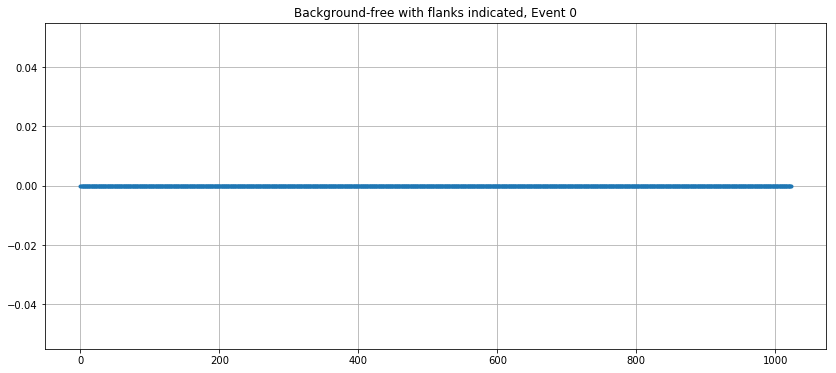

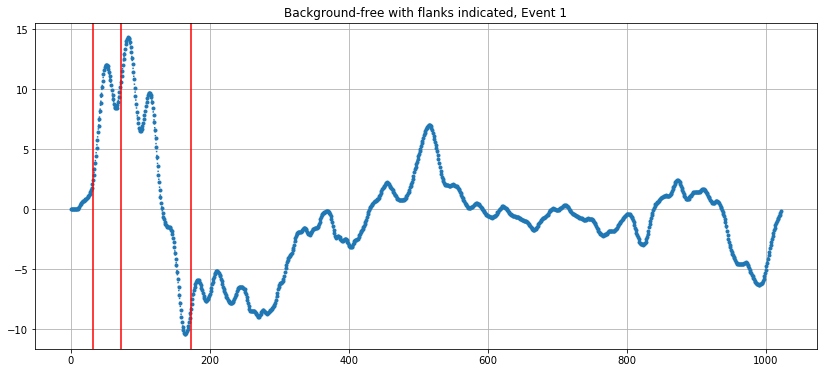

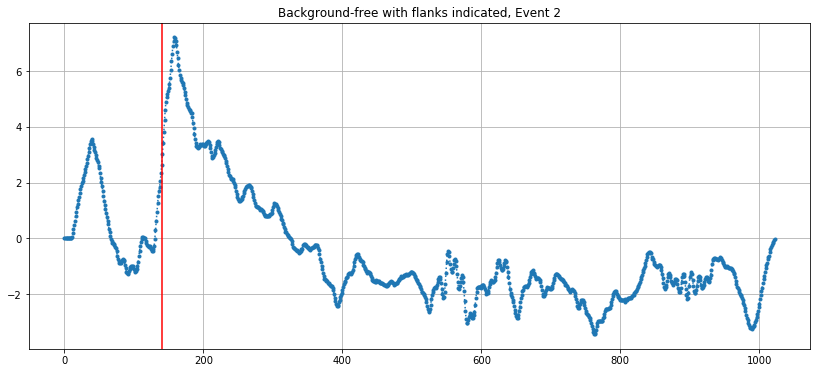

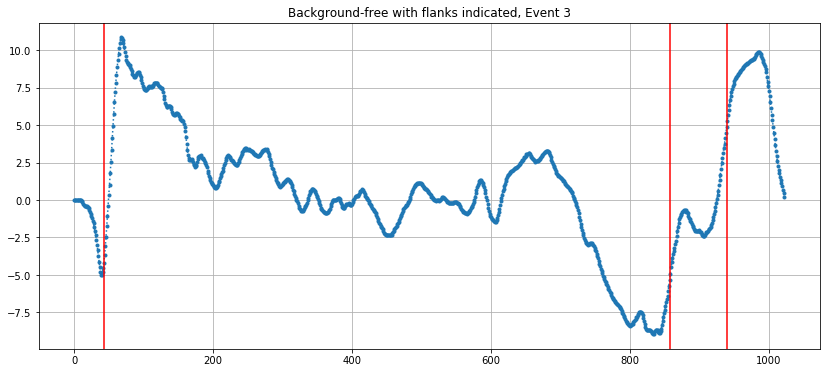

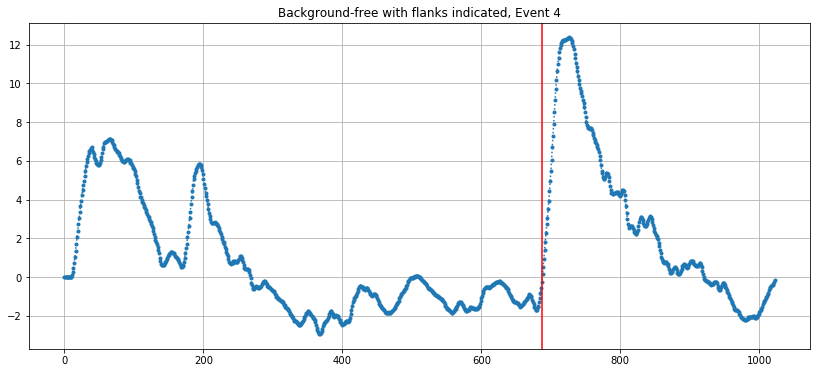

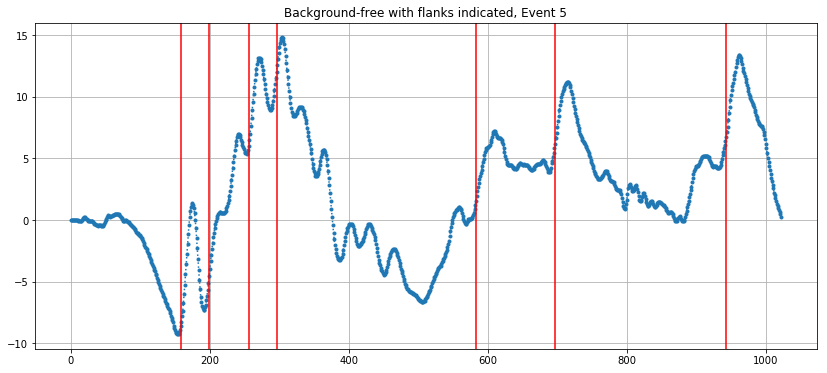

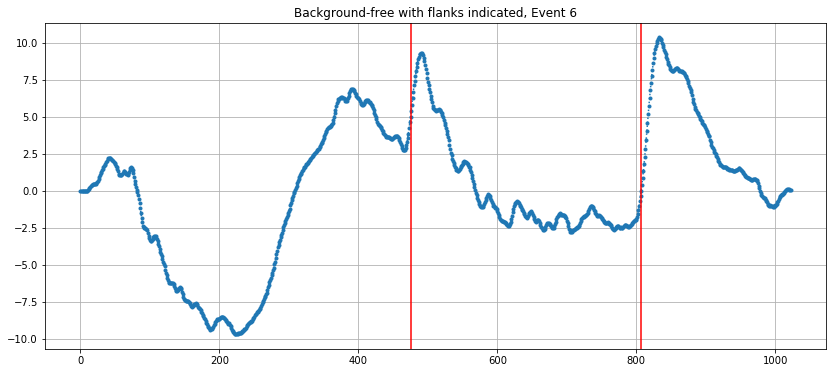

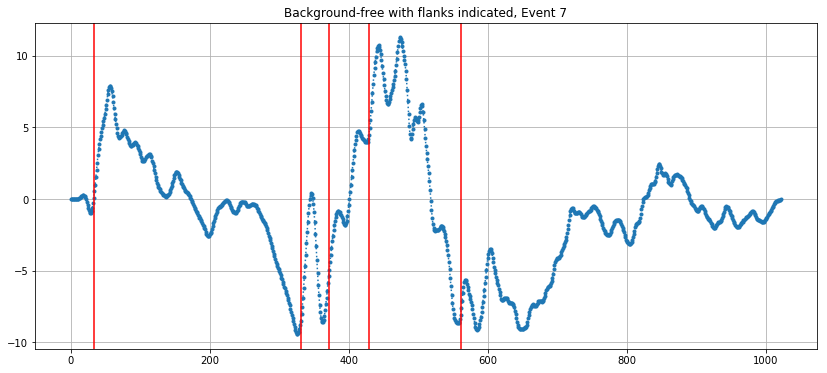

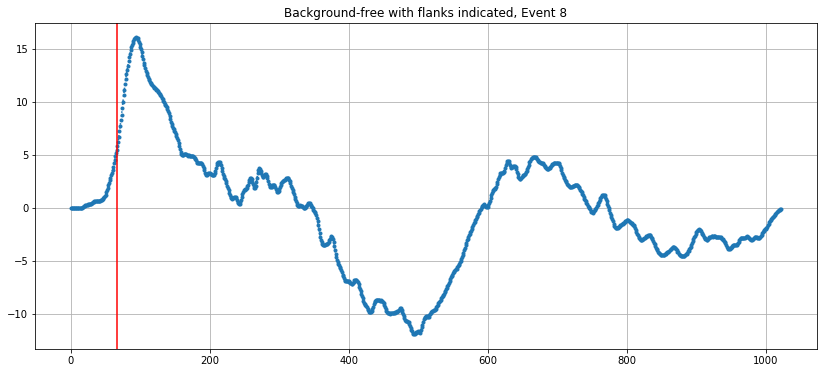

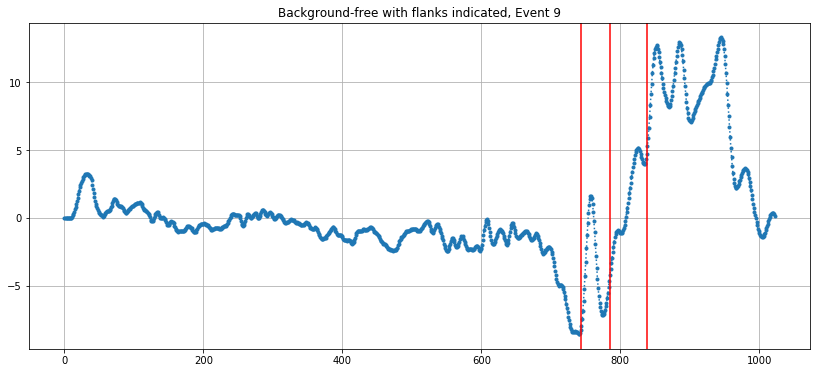

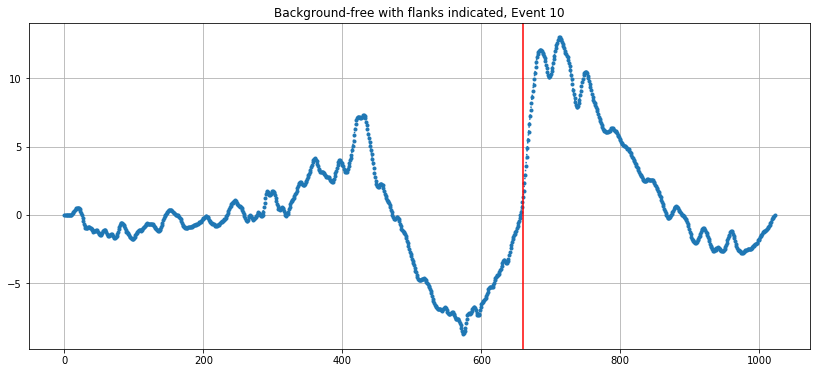

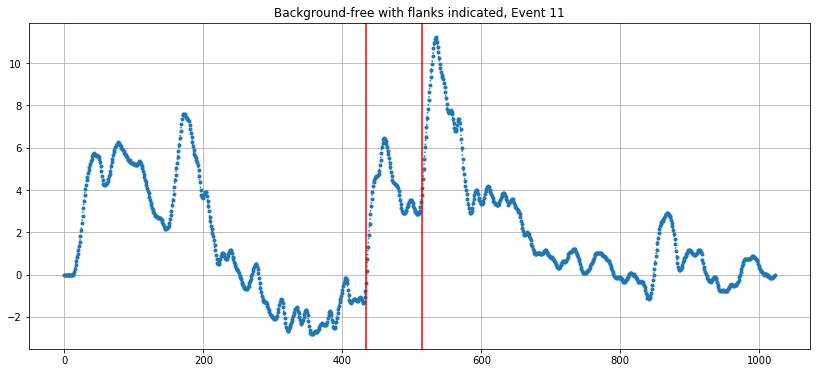

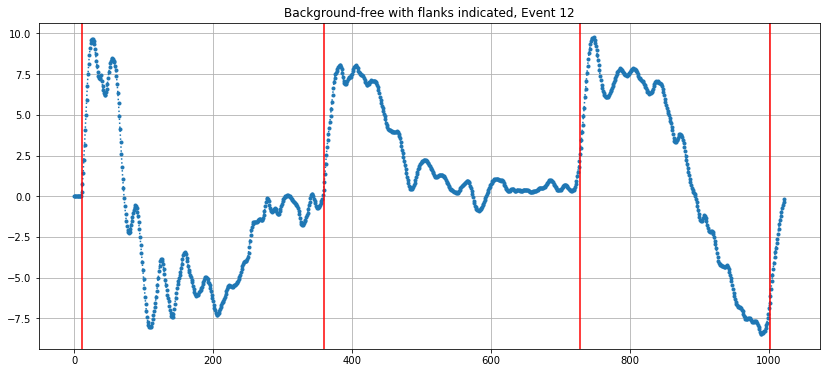

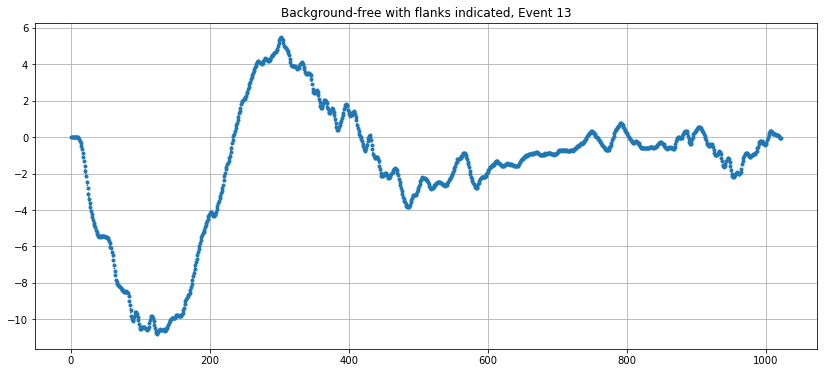

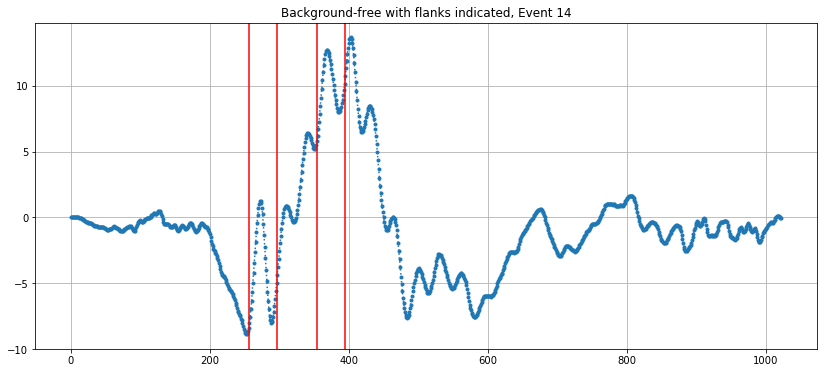

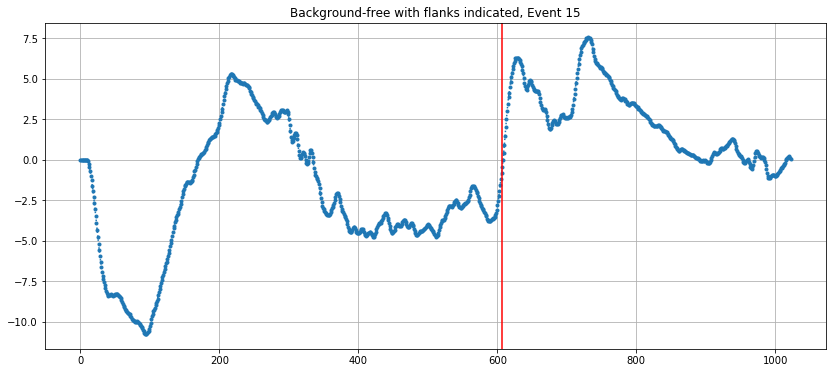

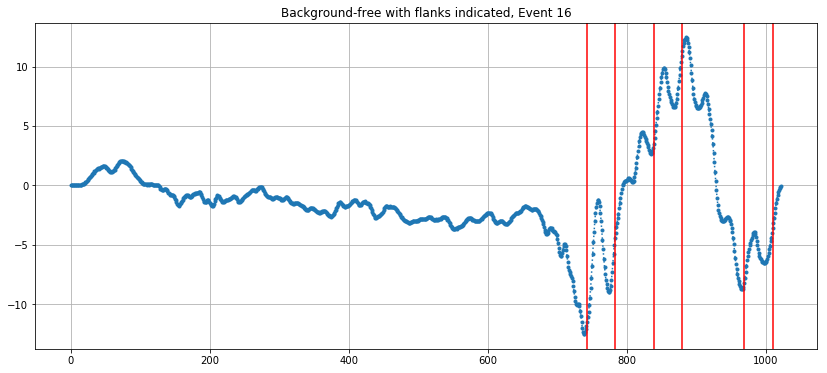

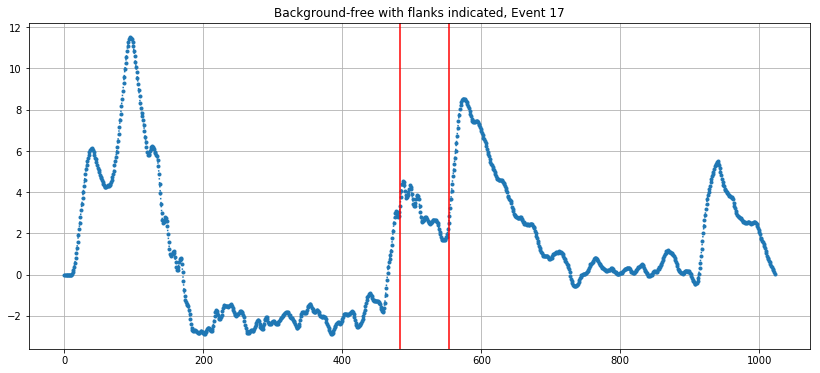

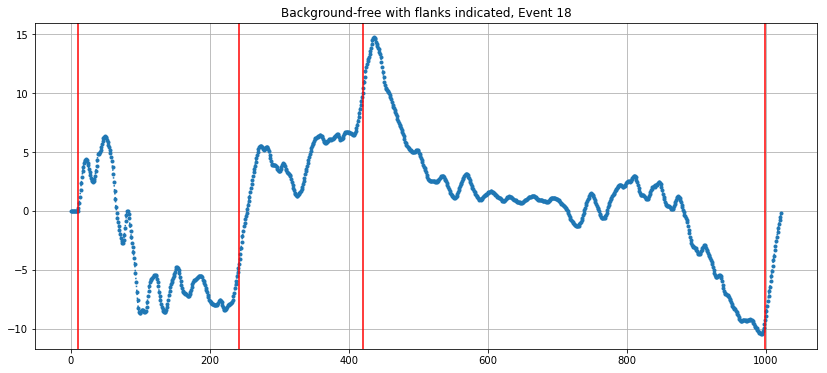

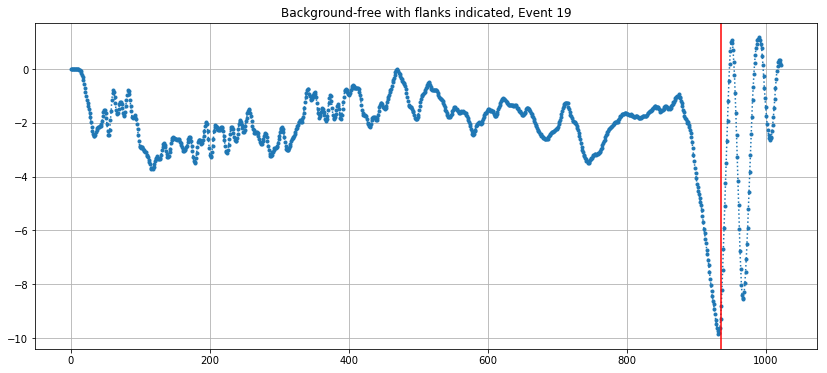

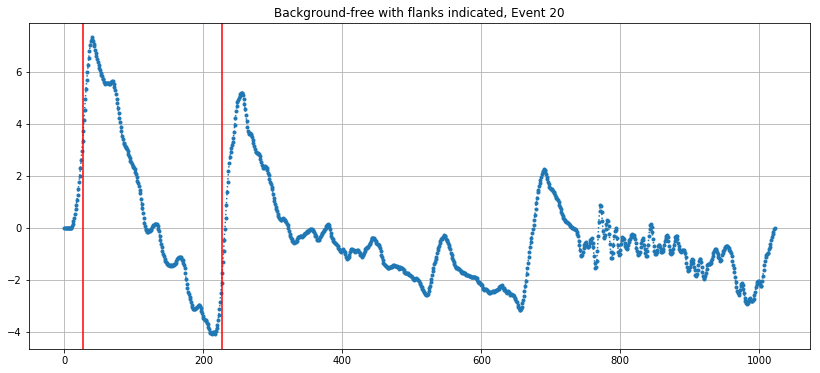

In [5]:
#Visualisation
for line_id in range(condata.shape[0]):
    if line_id >20:
        break
    plt.figure(figsize=(14, 6))
    plt.plot(condata[line_id], '.:')
    bar=[]
    for i in range(eventpos.shape[0]):
        if eventpos[i]==line_id:
            if slicepos[i]>0:
                bar=np.append(bar,slicepos[i])
    for xcoord in bar:
        plt.axvline(x=xcoord,c='r')
    plt.grid()
    plt.legend()
    plt.title("Background-free with flanks indicated, Event "+str(line_id))


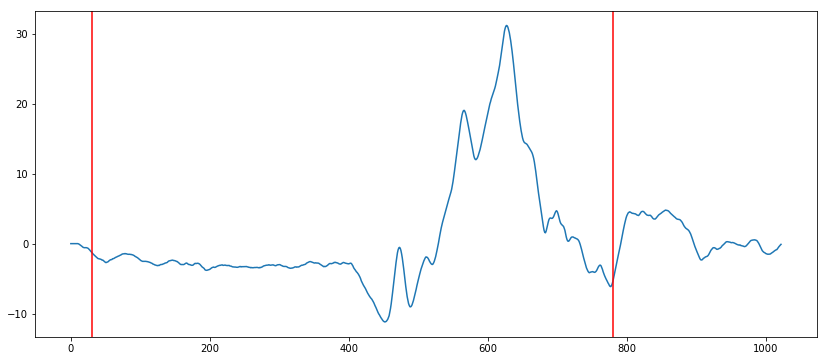

In [10]:
#Exemplaric Visulaizaiton of Integration procedure (Broken at the moment)
plt.figure(figsize=(14, 6))
plt.plot(condata[eventpos[showevent]])
plt.axvline(slicepos[showevent],c='r')
plt.axvline(30+arrivaltimes[showevent],c='r')
plt.plot([showmin1p,showmin2p],[showmin1,showmin2],c='y')

1 Photon events: 40.7752081914
2 Photon events: 70.2392507102
Crosstalk Probability: 172.259698541 +/-122.587018777 % 
Gain: 286.891192687


IndexError: list assignment index out of range

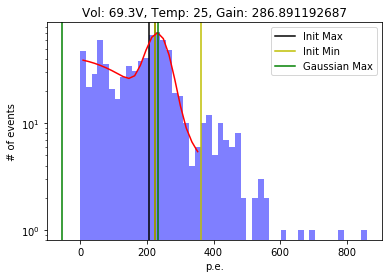

In [5]:
#Fingerplot
fig=plt.figure(1)
numbin=50
n, bins, patches = plt.hist(int_values, numbin, facecolor='blue', alpha=0.5,log=True,normed=False)

der=np.zeros(n.shape[0]-1)
for i in range(n.shape[0]-1):
    der[i]=n[i+1]-n[i]

max1p=np.argmax(n[1:])
tet=-1
i=0
while tet<=3: #Arbitrary (choose such that 2nd max is chosen correctly)
    tet=der[max1p+i]
    i+=1
min1p=max1p+i

max2p=np.argmax(n[min1p:])+min1p
tet=-1
i=0
while tet<=3: #Arbitrary (choose such that 2nd max is chosen correctly)
    tet=der[max2p+i]
    i+=1
min2p=max2p+i
#min2p=min2p+10
max1=bins[max1p]
min1=bins[min1p]
max2=bins[max2p]
min2=bins[min2p]

plt.axvline(bins[max1p],c='k',label="Init Max")
plt.axvline(bins[max2p],c='k')
plt.axvline(bins[min1p],c='y',label="Init Min")
plt.axvline(bins[min2p],c='y')

#Gaussian Fitting
bin_centres = (bins[:-1] + bins[1:])/2
fitdata=n[:min2p]

def gauss_sum(x, *p):
    '''Gaussian function used for fitting'''
    A1, mu1, sigma1, A2, mu2, sigma2 = p
    return A1*np.exp(-(x-mu1)**2/(2.*sigma1**2))+A2*np.exp(-(x-mu2)**2/(2.*sigma2**2))


# Initial guess of the coefficients as requiered by curve_fit
p0 = [100., bin_centres[max1p], 10.,100., bin_centres[max2p], 10.]

coeff, var_matrix = curve_fit(gauss_sum, bin_centres[:min2p], fitdata, p0=p0)
# Get the fitted curve
hist_fit = gauss_sum(bin_centres[:min2p], *coeff)

plt.plot(bin_centres[:min2p],hist_fit,c='r')
plt.xlabel("p.e.")
plt.ylabel("# of events")


norm1,mean1,std1,norm2,mean2,std2=coeff
cross_mean2=gauss_sum(mean2, *coeff)
cross_mean1=gauss_sum(mean1, *coeff)
cross_mean=cross_mean2/cross_mean1

plt.axvline(mean1,c='g',label="Gaussian Max")
plt.axvline(mean2,c='g')

cross_err=cross_mean*(abs(gauss_sum(mean1+std1,*coeff)-cross_mean1)/cross_mean1+abs(gauss_sum(mean2+std2,*coeff)-cross_mean2)/cross_mean2)

print("1 Photon events: "+str(cross_mean1))
print("2 Photon events: "+str(cross_mean2))
print("Crosstalk Probability: "+str(cross_mean*100)+" +/-"+str(cross_err*100)+" % ")
print("Gain: "+str(mean2-mean1))
plt.title("Vol: 69.3V, Temp: 25, Gain: "+str(mean2-mean1))
plt.legend()
def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r+').readlines()
    lines[line_num] = text
    out = open(file_name, 'w+')
    out.writelines(lines)
    out.close()



replace_line("Results/Diode_"+str(diode)+"/BV/plotdata.txt",point_num,"69.3 25 "+str(mean2-mean1))

fig.savefig("Results/Diode_"+str(diode)+"/BV/Point_"+str(point_num)+"/Fingerplot_BV_"+str(diode)+"_"+str(point_num)+".png")
fig.show()
#plt.close(fig)

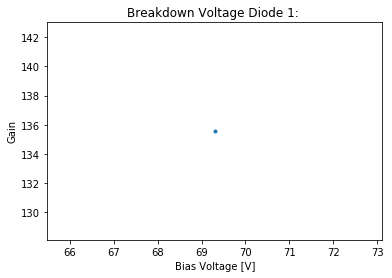

In [202]:
#Final Plot
volt=[]
gain=[]
file=open("Results/Diode_"+str(diode)+"/BV/plotdata.txt",'r')
for id,line in enumerate(file):
    if id!=0:
        for i,word in enumerate(line.split()):
            if i == 0:
                volt.append(word)
            if i == 1:
                temp=word
            if i == 2:
                gain.append(word)
file.close()
plt.plot(volt,gain,'.')
plt.title("Breakdown Voltage Diode "+str(diode)+": ")
plt.xlabel("Bias Voltage [V]")
plt.ylabel("Gain")